# 📊 Multi-Source Market Intelligence System:

This notebook builds an end-to-end data analysis pipeline using:
- Market price data (API)
- News headlines (GDELT)
- Sentiment-based feature engineering
- Time-series analysis and insights

In [300]:
!pip install pandas numpy requests matplotlib seaborn vaderSentiment

In [301]:
import requests #lets python talk to the internet
import pandas as pd
import numpy as np

import urllib.parse

import matplotlib.pyplot as plt
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #Imports VADER, a rule-based sentiment analyzer. Converts text -> numbers
# rule-based sentiment analyzer: dosen't train model but uses predefined positive and negative words for analysis and is used for short text

### 🔹 STEP 1: ENVIRONMENT SETUP & LIBRARY IMPORTS

In [302]:
pd.set_option("Display.max_columns", None) #Show all columns while displaying DataFrame
pd.set_option("Display.float_format","{:.4f}".format) #Format floating numbers to 4 decimal points

plt.style.use("seaborn-v0_8") #Pre-defined ploting theme
sns.set_context("talk") #Sclaes plot elements (paper = small, notebook = default, talk = large, poster = very large)

print("Environment Setup Complete!")

Environment Setup Complete!


### 🔹 STEP 2: FETCH MARKET DATA (CoinGecko API)

In this step, we fetch historical cryptocurrency market data.
This data will serve as the backbone for our time-series analysis.

In [303]:
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"

params = {
    "vs_currency": "usd", #Prices in USD
    "days": 180, #Last 180 days
    "interval": "daily" #daily data
}

response = requests.get(url, params = params) #API request

response.status_code #Anything other than 200 stop and debug

200

In [304]:
data = response.json() #Formats our response to JSON

data.keys() #Return keys of our data

dict_keys(['prices', 'market_caps', 'total_volumes'])

In [305]:
prices = data["prices"]
print(prices[:5]) #[timestamp, value] -> time and bitcoin price at that time

[[1752364800000, 117418.95745007684], [1752451200000, 119117.55666327637], [1752537600000, 119833.67446712355], [1752624000000, 117678.19493404306], [1752710400000, 118748.1627367753]]


In [306]:
price_df = pd.DataFrame(prices, columns=["timestamp","price"]) #converts list to structured table
price_df.head()

,timestamp,price
0,1752364800000,117418.9575
1,1752451200000,119117.5567
2,1752537600000,119833.6745
3,1752624000000,117678.1949
4,1752710400000,118748.1627


In [307]:
#Convert timestamp to date
price_df["date"] = pd.to_datetime(price_df["timestamp"], unit="ms").dt.date
price_df = price_df[["date","price"]]
price_df.head()

,date,price
0,2025-07-13,117418.9575
1,2025-07-14,119117.5567
2,2025-07-15,119833.6745
3,2025-07-16,117678.1949
4,2025-07-17,118748.1627


In [308]:
price_df.shape
price_df.info()
price_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    181 non-null    object 
 1   price   181 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB


,price
count,181.0000
mean,106233.7453
std,12039.7923
min,84682.6243
25%,92036.7255
50%,110708.6696
75%,115970.5849
max,124773.5082


In [309]:
price_df.isnull().sum()

date     0
price    0
dtype: int64

In [310]:
price_df.duplicated().sum()

np.int64(0)

In [311]:
price_df["date"].min(), price_df["date"].max()

(datetime.date(2025, 7, 13), datetime.date(2026, 1, 8))

In [312]:
price_df["price"] = price_df["price"].interpolate()
price_df = price_df.drop_duplicates()
price_df.isnull().sum()

date     0
price    0
dtype: int64

### 🔹 STEP 3: NEWS DATA COLLECTION (GDELT)

In [313]:
news_url = "https://api.gdeltproject.org/api/v2/doc/doc"

query = "(bitcoin OR cryptocurrency OR crypto market)" #News articles may not always say “bitcoin”.
start_date = "20250701000000"   # YYYYMMDDHHMMSS
end_date   = "20260101000000"

news_params = {
    "query": query, 
    "mode": "ArtList", #Return list of articles
    "format": "JSON",
    "maxrecords": 250, #Max articles per call
    "startdatetime": start_date,
    "enddatetime": end_date
}

In [314]:
url = news_url + "?" + urllib.parse.urlencode(news_params) #to see what we are requesting
url

'https://api.gdeltproject.org/api/v2/doc/doc?query=%28bitcoin+OR+cryptocurrency+OR+crypto+market%29&mode=ArtList&format=JSON&maxrecords=250&startdatetime=20250701000000&enddatetime=20260101000000'

In [315]:
news_response = requests.get(url)

news_response.status_code

200

In [316]:
news_data = news_response.json()

news_data.keys()

dict_keys(['articles'])

In [317]:
articles = news_data["articles"]

len(articles) #how many news articles we fetched in this API

250

In [318]:
news_df = pd.DataFrame(articles)

news_df.head()

,url,url_mobile,title,seendate,socialimage,domain,language,sourcecountry
0,https://finance.yahoo.com/news/buy-bitcoin-whi...,,"Should You Buy Bitcoin While It Under $100 , 0...",20251207T201500Z,https://s.yimg.com/ny/api/res/1.2/uQnbh7RuW9ti...,finance.yahoo.com,English,United States
1,https://www.theguardian.com/technology/2025/de...,,Cryptocurrency slump erases 2025 financial gai...,20251229T181500Z,https://i.guim.co.uk/img/media/388a1a195d6f4c9...,theguardian.com,English,United Kingdom
2,https://finance.yahoo.com/news/bitcoin-ethereu...,,"Bitcoin , Ethereum , Dogecoin Trade Flat , Whi...",20251224T050000Z,https://media.zenfs.com/en/benzinga_79/475dc76...,finance.yahoo.com,English,United States
3,https://charter97.org/en/news/2025/11/6/661980/,https://qnt91x.c97.org/en/news/2025/11/6/661980/,Trump : Were Turning The U . S . Into A Bitcoi...,20251106T070000Z,https://i.c97.org/ai/272816/aux-head-151359577...,charter97.org,English,Belarus
4,https://finance.yahoo.com/news/2-best-cryptocu...,,The 2 Best Cryptocurrencies to Buy With $100 R...,20251220T024500Z,https://s.yimg.com/ny/api/res/1.2/pcThSGfxB0wO...,finance.yahoo.com,English,United States


In [319]:
news_df = news_df[["seendate","title","domain"]]

In [320]:
news_df["date"] = pd.to_datetime(news_df["seendate"]).dt.date
news_df = news_df.drop(columns=["seendate"])

news_df.head()

,title,domain,date
0,"Should You Buy Bitcoin While It Under $100 , 0...",finance.yahoo.com,2025-12-07
1,Cryptocurrency slump erases 2025 financial gai...,theguardian.com,2025-12-29
2,"Bitcoin , Ethereum , Dogecoin Trade Flat , Whi...",finance.yahoo.com,2025-12-24
3,Trump : Were Turning The U . S . Into A Bitcoi...,charter97.org,2025-11-06
4,The 2 Best Cryptocurrencies to Buy With $100 R...,finance.yahoo.com,2025-12-20


In [321]:
news_df.shape
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   250 non-null    object
 1   domain  250 non-null    object
 2   date    250 non-null    object
dtypes: object(3)
memory usage: 6.0+ KB


In [322]:
news_df.isnull().sum()

title     0
domain    0
date      0
dtype: int64

In [323]:
(news_df["title"].str.strip() == "").sum() #check for empty or blank titles

np.int64(0)

In [324]:
news_df.duplicated(subset = ["title","date"]).sum()

np.int64(29)

In [325]:
news_df["date"].min(),news_df["date"].max()

(datetime.date(2025, 10, 3), datetime.date(2026, 1, 1))

In [326]:
news_df = news_df.reset_index(drop = True) #reset the index of dataFrame

### 🔹 STEP 4: SENTIMENT FEATURE ENGINEERING (VADER)

In this step, we convert news headlines into numeric sentiment scores
using a rule-based sentiment analyzer. These scores will later be
aggregated and aligned with market data.

In [327]:
analyzer = SentimentIntensityAnalyzer()

In [328]:
sample_text = news_df.loc[0,"title"]
sample_text

'Should You Buy Bitcoin While It Under $100 , 000 ? '

In [329]:
analyzer.polarity_scores(sample_text)
# neg = negative, neu = neutral, pos = positive, compound = overall sentiment(-1 to +1)
#Compound: >=  +0.05 positive
#          <=  -0.05 negative
#      between neutral

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [330]:
news_df["sentiment_dict"] = news_df["title"].apply(
    lambda x: analyzer.polarity_scores(x)
)

In [331]:
news_df.head()

,title,domain,date,sentiment_dict
0,"Should You Buy Bitcoin While It Under $100 , 0...",finance.yahoo.com,2025-12-07,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,Cryptocurrency slump erases 2025 financial gai...,theguardian.com,2025-12-29,"{'neg': 0.0, 'neu': 0.468, 'pos': 0.532, 'comp..."
2,"Bitcoin , Ethereum , Dogecoin Trade Flat , Whi...",finance.yahoo.com,2025-12-24,"{'neg': 0.0, 'neu': 0.891, 'pos': 0.109, 'comp..."
3,Trump : Were Turning The U . S . Into A Bitcoi...,charter97.org,2025-11-06,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,The 2 Best Cryptocurrencies to Buy With $100 R...,finance.yahoo.com,2025-12-20,"{'neg': 0.0, 'neu': 0.682, 'pos': 0.318, 'comp..."


In [332]:
news_df["sentiment_neg"] = news_df["sentiment_dict"].apply(lambda x: x["neg"])
news_df["sentiment_neu"] = news_df["sentiment_dict"].apply(lambda x: x["neu"])
news_df["sentiment_pos"] = news_df["sentiment_dict"].apply(lambda x: x["pos"])
news_df["sentiment_compound"] = news_df["sentiment_dict"].apply(lambda x: x["compound"])

news_df = news_df.drop(columns=["sentiment_dict"])

In [333]:
news_df.head()

,title,domain,date,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
0,"Should You Buy Bitcoin While It Under $100 , 0...",finance.yahoo.com,2025-12-07,0.0000,1.0000,0.0000,0.0000
1,Cryptocurrency slump erases 2025 financial gai...,theguardian.com,2025-12-29,0.0000,0.4680,0.5320,0.8442
2,"Bitcoin , Ethereum , Dogecoin Trade Flat , Whi...",finance.yahoo.com,2025-12-24,0.0000,0.8910,0.1090,0.4215
3,Trump : Were Turning The U . S . Into A Bitcoi...,charter97.org,2025-11-06,0.0000,1.0000,0.0000,0.0000
4,The 2 Best Cryptocurrencies to Buy With $100 R...,finance.yahoo.com,2025-12-20,0.0000,0.6820,0.3180,0.6369


### 🔹 STEP 5: DAILY SENTIMENT AGGREGATION

As our market price data has price per day whereas news consists of various articles every day so we need to aggregate the articles per day in our news dataFrame

In [334]:
news_df["date"].value_counts().head()

date
2025-12-01    21
2025-11-24    11
2025-12-02     9
2025-12-29     8
2025-11-01     8
Name: count, dtype: int64

In [335]:
daily_sentiment = (
    news_df.groupby("date").agg(
        avg_compound=("sentiment_compound", "mean"),
        avg_positive=("sentiment_pos", "mean"),
        avg_negative=("sentiment_neg", "mean"),
        avg_neutral=("sentiment_neu", "mean"),
        article_count=("sentiment_compound", "count") #News volume
    )
    .reset_index() #Converts date to back to column
)

daily_sentiment.head()

,date,avg_compound,avg_positive,avg_negative,avg_neutral,article_count
0,2025-10-03,0.1327,0.1123,0.0313,0.8564,7
1,2025-10-04,0.2533,0.1202,0.0000,0.8798,4
2,2025-10-05,-0.0512,0.0000,0.0454,0.9546,5
3,2025-10-06,0.1346,0.1295,0.0580,0.8125,2
4,2025-10-08,0.1027,0.1360,0.1170,0.7480,1


### 🔹 STEP 5: MERGING MARKET DATA WITH DAILY SENTIMENT

In this step, we merge daily market price data with
aggregated daily news sentiment to create a unified
analysis-ready dataset.

In [336]:
price_df.head()

,date,price
0,2025-07-13,117418.9575
1,2025-07-14,119117.5567
2,2025-07-15,119833.6745
3,2025-07-16,117678.1949
4,2025-07-17,118748.1627


In [337]:
daily_sentiment.head()

,date,avg_compound,avg_positive,avg_negative,avg_neutral,article_count
0,2025-10-03,0.1327,0.1123,0.0313,0.8564,7
1,2025-10-04,0.2533,0.1202,0.0000,0.8798,4
2,2025-10-05,-0.0512,0.0000,0.0454,0.9546,5
3,2025-10-06,0.1346,0.1295,0.0580,0.8125,2
4,2025-10-08,0.1027,0.1360,0.1170,0.7480,1


In [338]:
#Merging on date column
final_df = price_df.merge(daily_sentiment, on = "date", how = "left")

# Why left? : keep all market date and attach sentiment only if available as missing sentiment !=  missing price

final_df.head()

,date,price,avg_compound,avg_positive,avg_negative,avg_neutral,article_count
0,2025-07-13,117418.9575,NaN,NaN,NaN,NaN,NaN
1,2025-07-14,119117.5567,NaN,NaN,NaN,NaN,NaN
2,2025-07-15,119833.6745,NaN,NaN,NaN,NaN,NaN
3,2025-07-16,117678.1949,NaN,NaN,NaN,NaN,NaN
4,2025-07-17,118748.1627,NaN,NaN,NaN,NaN,NaN


In [339]:
final_df.tail()

,date,price,avg_compound,avg_positive,avg_negative,avg_neutral,article_count
176,2026-01-05,91373.2159,NaN,NaN,NaN,NaN,NaN
177,2026-01-06,93926.7956,NaN,NaN,NaN,NaN,NaN
178,2026-01-07,93666.8639,NaN,NaN,NaN,NaN,NaN
179,2026-01-08,91257.1554,NaN,NaN,NaN,NaN,NaN
180,2026-01-08,89788.8330,NaN,NaN,NaN,NaN,NaN


In [340]:
final_df.isnull().sum() #sentiment are null as there is no relevant news article on that day

date               0
price              0
avg_compound     108
avg_positive     108
avg_negative     108
avg_neutral      108
article_count    108
dtype: int64

In [341]:
final_df.info()
final_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           181 non-null    object 
 1   price          181 non-null    float64
 2   avg_compound   73 non-null     float64
 3   avg_positive   73 non-null     float64
 4   avg_negative   73 non-null     float64
 5   avg_neutral    73 non-null     float64
 6   article_count  73 non-null     float64
dtypes: float64(6), object(1)
memory usage: 10.0+ KB


,price,avg_compound,avg_positive,avg_negative,avg_neutral,article_count
count,181.0000,73.0000,73.0000,73.0000,73.0000,73.0000
mean,106233.7453,0.0422,0.0718,0.0610,0.8672,3.4247
std,12039.7923,0.2467,0.0740,0.0671,0.0792,2.8960
min,84682.6243,-0.6249,0.0000,0.0000,0.6985,1.0000
25%,92036.7255,-0.0705,0.0000,0.0000,0.8160,2.0000
50%,110708.6696,0.0169,0.0557,0.0510,0.8690,3.0000
75%,115970.5849,0.2001,0.1117,0.0920,0.9187,4.0000
max,124773.5082,0.5973,0.3015,0.2856,1.0000,21.0000


### 🔹 STEP 6: HANDLING MISSING SENTIMENT VALUES

After merging market and sentiment data, some days contain
missing sentiment values due to the absence of news articles.
These are handled explicitly to preserve semantic meaning.

In [342]:
final_df[final_df["avg_compound"].isnull()].head()

,date,price,avg_compound,avg_positive,avg_negative,avg_neutral,article_count
0,2025-07-13,117418.9575,NaN,NaN,NaN,NaN,NaN
1,2025-07-14,119117.5567,NaN,NaN,NaN,NaN,NaN
2,2025-07-15,119833.6745,NaN,NaN,NaN,NaN,NaN
3,2025-07-16,117678.1949,NaN,NaN,NaN,NaN,NaN
4,2025-07-17,118748.1627,NaN,NaN,NaN,NaN,NaN


In [343]:
#Instead of dropping missing values from sentiment, we can replace null with 0 (nutral sentiment) as they are days with no news so no sentiment
final_df["avg_compound"] = final_df["avg_compound"].fillna(0)
final_df["avg_positive"] = final_df["avg_positive"].fillna(0)
final_df["avg_negative"] = final_df["avg_negative"].fillna(0)
final_df["avg_neutral"] = final_df["avg_neutral"].fillna(0)
final_df["article_count"] = final_df["article_count"].fillna(0)

In [344]:
final_df.isnull().sum()

date             0
price            0
avg_compound     0
avg_positive     0
avg_negative     0
avg_neutral      0
article_count    0
dtype: int64

In [345]:
final_df.head()

,date,price,avg_compound,avg_positive,avg_negative,avg_neutral,article_count
0,2025-07-13,117418.9575,0.0000,0.0000,0.0000,0.0000,0.0000
1,2025-07-14,119117.5567,0.0000,0.0000,0.0000,0.0000,0.0000
2,2025-07-15,119833.6745,0.0000,0.0000,0.0000,0.0000,0.0000
3,2025-07-16,117678.1949,0.0000,0.0000,0.0000,0.0000,0.0000
4,2025-07-17,118748.1627,0.0000,0.0000,0.0000,0.0000,0.0000


In [346]:
final_df.tail()

,date,price,avg_compound,avg_positive,avg_negative,avg_neutral,article_count
176,2026-01-05,91373.2159,0.0000,0.0000,0.0000,0.0000,0.0000
177,2026-01-06,93926.7956,0.0000,0.0000,0.0000,0.0000,0.0000
178,2026-01-07,93666.8639,0.0000,0.0000,0.0000,0.0000,0.0000
179,2026-01-08,91257.1554,0.0000,0.0000,0.0000,0.0000,0.0000
180,2026-01-08,89788.8330,0.0000,0.0000,0.0000,0.0000,0.0000


### 🔹 STEP 7: CREATING SENTIMENT REGIMES


In this step, we categorize daily sentiment scores into
interpretable sentiment regimes (Positive, Neutral, Negative)
to enable regime-based analysis. A regime is a state or condition of the system.

In [347]:
# creating a new column to explicitly defin type of sentiment on the basis of avg_sentiment
def classify_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else: 
        return "Neutral"

In [348]:
final_df["sentiment_regime"] = final_df["avg_compound"].apply(classify_sentiment)
final_df.head()

,date,price,avg_compound,avg_positive,avg_negative,avg_neutral,article_count,sentiment_regime
0,2025-07-13,117418.9575,0.0000,0.0000,0.0000,0.0000,0.0000,Neutral
1,2025-07-14,119117.5567,0.0000,0.0000,0.0000,0.0000,0.0000,Neutral
2,2025-07-15,119833.6745,0.0000,0.0000,0.0000,0.0000,0.0000,Neutral
3,2025-07-16,117678.1949,0.0000,0.0000,0.0000,0.0000,0.0000,Neutral
4,2025-07-17,118748.1627,0.0000,0.0000,0.0000,0.0000,0.0000,Neutral


In [349]:
final_df["sentiment_regime"].value_counts()

sentiment_regime
Neutral     127
Positive     31
Negative     23
Name: count, dtype: int64

### 🔹 STEP 8: PRICE RETURNS & VOLATILITY FEATURE ENGINEERING

In this step, we transform raw price data into daily returns
and volatility measures to enable meaningful market analysis.
- returns → how much price changes
- volatility → how unstable price is

In [350]:
final_df = final_df.sort_values("date").reset_index(drop = True)

In [351]:
final_df["daily_return"] = final_df["price"].pct_change()

# Percentage Change
# pct = (price[t] - price[t-1])/ price[t-1]

final_df[["date","price","daily_return"]].head()
# first day return is NaN as there is no previous day

,date,price,daily_return
0,2025-07-13,117418.9575,NaN
1,2025-07-14,119117.5567,0.0145
2,2025-07-15,119833.6745,0.0060
3,2025-07-16,117678.1949,-0.0180
4,2025-07-17,118748.1627,0.0091


In [352]:
# Create rolling volatility (7-day)
final_df["volatility_7d"] = (final_df["daily_return"].rolling(window=7).std()) 

# What is Volatility: Markets often react to negative news with volatility spikes
# Higher volatility → more uncertainty && Lower volatility → stability

final_df["volatility_14d"] = (final_df["daily_return"].rolling(window=14).std()) 

final_df["volatility_30d"] = (final_df["daily_return"].rolling(window=30).std()) 

In [353]:
final_df.head(31)

# daily_return start at second day
# volatility start at 8th day with rolling volatility for the first 7 day

,date,price,avg_compound,avg_positive,avg_negative,avg_neutral,article_count,sentiment_regime,daily_return,volatility_7d,volatility_14d,volatility_30d
0,2025-07-13,117418.9575,0.0000,0.0000,0.0000,0.0000,0.0000,Neutral,NaN,NaN,NaN,NaN
1,2025-07-14,119117.5567,0.0000,0.0000,0.0000,0.0000,0.0000,Neutral,0.0145,NaN,NaN,NaN
2,2025-07-15,119833.6745,0.0000,0.0000,0.0000,0.0000,0.0000,Neutral,0.0060,NaN,NaN,NaN
3,2025-07-16,117678.1949,0.0000,0.0000,0.0000,0.0000,0.0000,Neutral,-0.0180,NaN,NaN,NaN
4,2025-07-17,118748.1627,0.0000,0.0000,0.0000,0.0000,0.0000,Neutral,0.0091,NaN,NaN,NaN
5,2025-07-18,119445.3652,0.0000,0.0000,0.0000,0.0000,0.0000,Neutral,0.0059,NaN,NaN,NaN
6,2025-07-19,117988.9466,0.0000,0.0000,0.0000,0.0000,0.0000,Neutral,-0.0122,NaN,NaN,NaN
7,2025-07-20,117901.6266,0.0000,0.0000,0.0000,0.0000,0.0000,Neutral,-0.0007,0.0118,NaN,NaN
8,2025-07-21,117256.9208,0.0000,0.0000,0.0000,0.0000,0.0000,Neutral,-0.0055,0.0102,NaN,NaN
9,2025-07-22,117482.4698,0.0000,0.0000,0.0000,0.0000,0.0000,Neutral,0.0019,0.0097,NaN,NaN


### 🔹 STEP 9: EXPLORATORY DATA ANALYSIS (EDA)

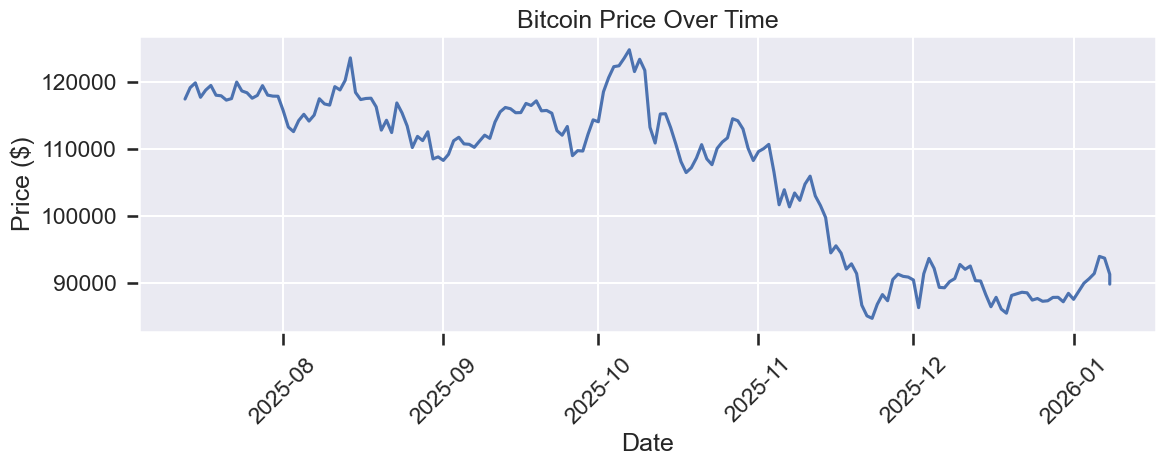

In [354]:
# A. Price Trend over Time
plt.figure(figsize = (12,5))

plt.plot(final_df["date"],final_df["price"])

plt.title("Bitcoin Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price ($)")

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Analysis:
- The price shows clear periods of upward and downward movement.
- The market is non-stationary (it trends over time).
- This confirms why analyzing returns instead of raw prices is necessary.

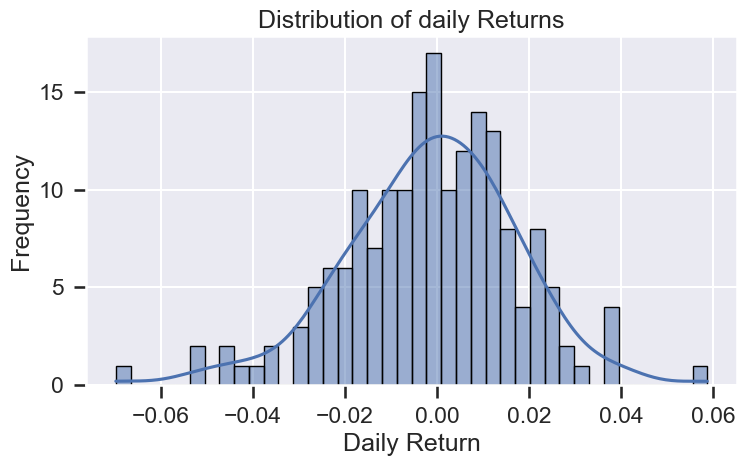

In [355]:
# B. Daily Returns distribution

plt.figure(figsize = (8,5))

sns.histplot(final_df["daily_return"].dropna(), bins=40, kde=True)

plt.title("Distribution of daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Analysis:
- Returns are centered around zero (price did not change), Most daily changes are small, A few extreme values exist on both sides.
- The market usually moves moderately but occasionally experiences large shocks.
- This is typical of financial markets and indicates risk concentration in extreme events.

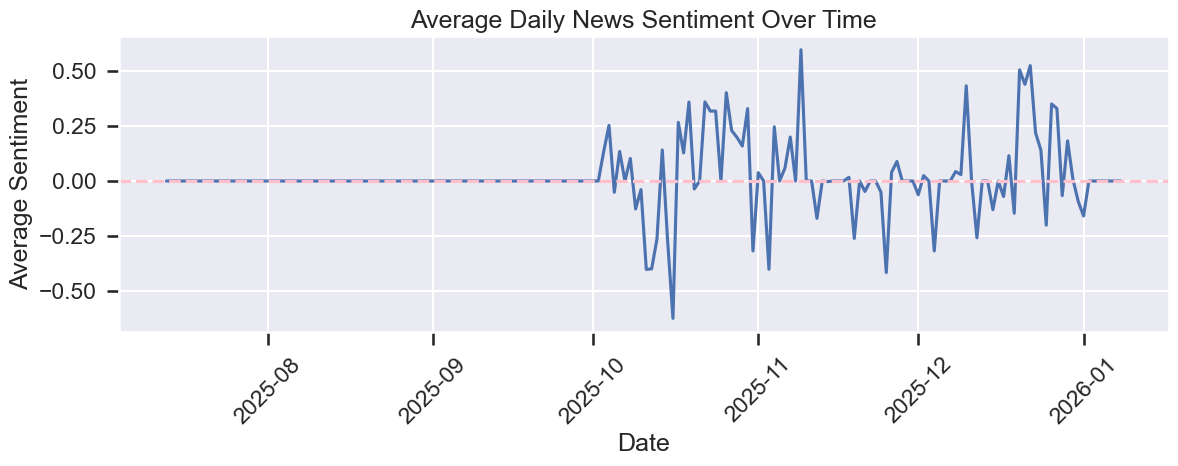

In [356]:
# C. Sentiment Over Time
plt.figure(figsize = (12,5))

plt.plot(final_df["date"], final_df["avg_compound"])
plt.axhline(0, linestyle = "--", color ="pink")

plt.title("Average Daily News Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Average Sentiment")

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Analysis:
- News sentiment is event-driven, not continuous.
- Major events strongly influence sentiment on specific days.

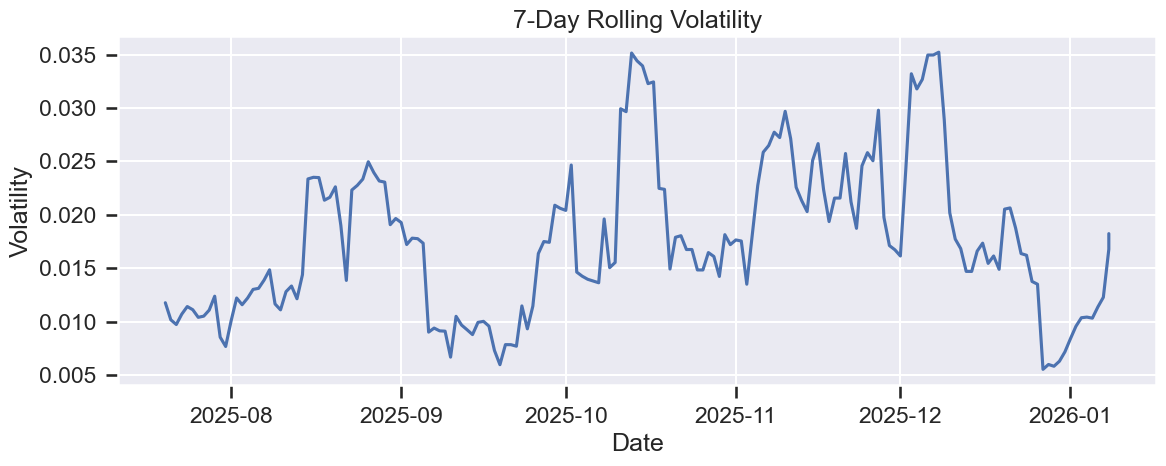

In [357]:
# D. Volatility Over Time
plt.figure(figsize=(12,5))

plt.plot(final_df["date"],final_df["volatility_7d"])

plt.title("7-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")

plt.tight_layout()
plt.show()

Analysis:
- Volatility clusters in certain periods, Calm periods are followed by spikes in volatility.
- Market uncertainty is not constant.
- Risk tends to increase during specific periods rather than randomly, This suggests external factors (like news) may influence instability.

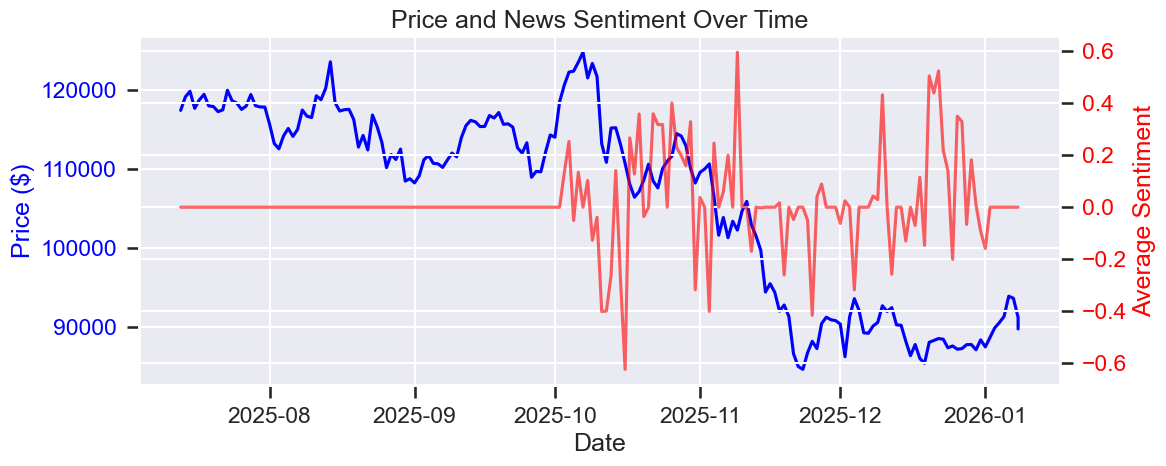

In [358]:
# E. Price vs Sentiment
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(final_df["date"], final_df["price"], color = "blue")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price ($)", color= "blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(final_df["date"], final_df["avg_compound"], color = "red", alpha =0.6)
ax2.set_ylabel("Average Sentiment", color= "red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Price and News Sentiment Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Analysis:
- Some sentiment spikes align with price movements. In other cases, price moves without strong sentiment change.
- News sentiment is not the sole driver of price.
- This supports a descriptive, not causal interpretation.

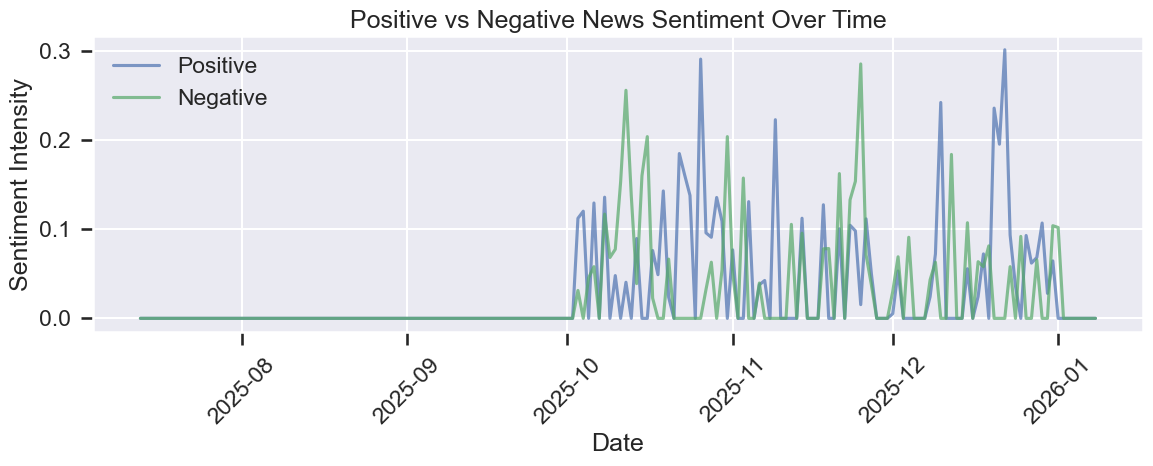

In [359]:
# F. Positive vs Negative Sentiment 
plt.figure(figsize=(12,5))

plt.plot(final_df["date"],final_df["avg_positive"], label="Positive", alpha = 0.7)
plt.plot(final_df["date"],final_df["avg_negative"], label="Negative", alpha = 0.7)

plt.title("Positive vs Negative News Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Sentiment Intensity")

plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Analysis: 
- Positive and negative sentiment vary independently.
- Positive sentiment does not always dominate even during price increases.
- Compound sentiment can hide sentiment imbalance.
- Negative tone often appears stronger and more volatile.
- Separating sentiment components provides deeper insight than using a single score.

### 🧠 Conclusion
News sentiment does not consistently predict returns, but negative sentiment regimes are associated with higher market volatility, indicating increased risk during adverse news cycles.

### 🔹 STEP 10: COMPARING RETURNS & VOLATILITY ACROSS SENTIMENT REGIMES

compare returns and volatility
across Positive, Neutral, and Negative sentiment regimes.

In [360]:
# A. Average Daily Return by Sentiment Regime
regime_returns = (
    final_df.groupby("sentiment_regime")["daily_return"].mean()
)

regime_returns

# Average direction of market movement
# Whether negative days tend to have worse returns
# Whether positive days outperform neutral days

sentiment_regime
Negative   -0.0017
Neutral    -0.0014
Positive   -0.0007
Name: daily_return, dtype: float64

Analysis:
- Average daily returns differ slightly across sentiment regimes.
- Positive sentiment days tend to have marginally higher returns.
- Negative sentiment days often show weaker or negative average returns.
- News sentiment has some association with market direction, but the effect is modest.
- Sentiment alone is not a strong predictor of daily returns.

In [361]:
# B. Return Volatility by Sentiment Regime
regime_volatility = (
    final_df.groupby("sentiment_regime")["daily_return"].std()
)

regime_volatility

# Risk is often more important than return
# Negative news may increase uncertainty
# Volatility reveals stress, not direction

sentiment_regime
Negative   0.0230
Neutral    0.0181
Positive   0.0187
Name: daily_return, dtype: float64

Analysis:
- Volatility measures how much and how often prices move up and down.
- High volatility → prices change a lot, Low volatility → prices change a little
- Volatility is noticeably higher during negative sentiment regimes.
- Negative news environments are associated with greater market uncertainty.
- Sentiment impacts risk more than return direction.

In [362]:
# C. Rolling Volatility Comparison (7-Day)
regime_vol_7d = (
    final_df
    .groupby("sentiment_regime")["volatility_7d"]
    .mean()
)
regime_vol_7d

# Sustained risk levels across regimes
# Whether bad sentiment leads to prolonged instability

sentiment_regime
Negative   0.0201
Neutral    0.0166
Positive   0.0189
Name: volatility_7d, dtype: float64

Analysis:
- Rolling volatility remains elevated during negative sentiment periods.
- Negative sentiment has a persistent effect on market risk, not just a one-day impact.

In [363]:
regime_summary = pd.DataFrame({
    "avg_daily_return": regime_returns,
    "return_volatility": regime_volatility,
    "avg_7d_volatility": regime_vol_7d
})

regime_summary

,avg_daily_return,return_volatility,avg_7d_volatility
sentiment_regime,,,
Negative,-0.0017,0.0230,0.0201
Neutral,-0.0014,0.0181,0.0166
Positive,-0.0007,0.0187,0.0189


Analysis:
- Negative sentiment regimes combine lower returns with higher volatility.
- Positive regimes show slightly better stability.
- Market behavior clearly differs by sentiment regime.
- Regime-based analysis provides clearer insight than looking at averages alone.

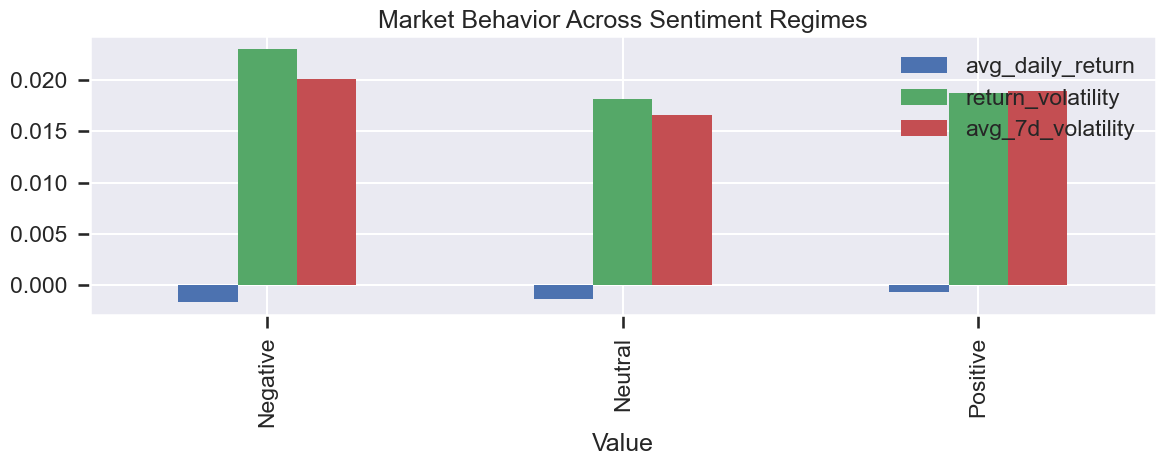

In [364]:
regime_summary.plot(kind = "bar", figsize = (12,5))

plt.title("Market Behavior Across Sentiment Regimes")
plt.xlabel("Value")

plt.tight_layout()
plt.show()

# 🧠 Conclusion
Negative sentiment regimes are associated with higher market volatility, while returns vary only modestly across sentiment states, suggesting sentiment affects risk more than direction.